# Anomaly Detection

Anomaly detection uses different models to detect anomalous data in a stream.  There are many models to chose from and the best choice depends on the characteristics of the data.  Is the data normally distributed?  Is there frequent baseline changes?  Is the data highly seasonal?  Those are some of the questions you need to ask about the data before deciding on a model.

## Normally Distributed Anomalies

If the data is normally distributed, mean and standard deviation can easily be used to detect anomalies.  Nearly impossible values can be thought as anomalous.  

### Detecting Outliers

In normally distributed data, the mean of a series and +/- 3 standard deviations away would cover 99.7% of all values.  Any numbers outside of that threshold, would be considered anomalous.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm                                                                                                                          
import statsmodels.formula.api as smf                                                                                                                 
import statsmodels.tsa.api as smt   

%matplotlib inline

/Users/michaelbeale/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [68]:
# create a normally distributed array
np.random.seed(42)
mu, sigma = 50, 5
y = np.random.normal(mu, sigma, 1000)
x = [x for x in range(1000)]

#### Histogram

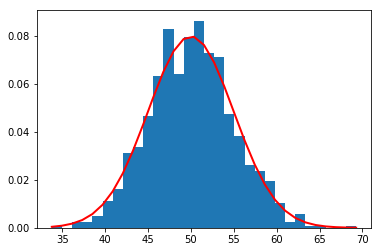

In [69]:
count, bins, ignored = plt.hist(y, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
                linewidth=2, color='r')

#### Plot the Outliers

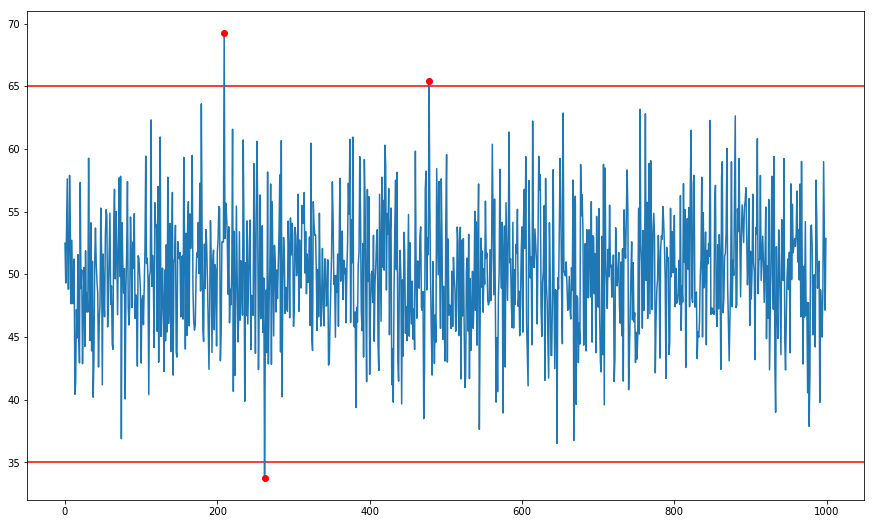

In [70]:
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)

# plot upper bounds
ax.axhline(mu+(3*sigma), color='r')
# plot lower bounds
ax.axhline(mu-(3*sigma), color='r')

ax.plot(x, y)

# highlight outliers
out_x, out_y = zip(*[[x, y] for x,y in enumerate(y) if y < mu-(3*sigma) or y > mu+(3*sigma)])

ax.plot(out_x, out_y, 'ro')


There are 3 outliers (highlighted by red dots) in this data which is as expected (1000 samples * .03 = 3). This data is anomalous but the threshold could be adjusted depending on what is actually considered anamolous.  For instance you could use +/- 4 times standard deviation (99.994% or 1 in 157887 events).  Below is a table of Table of numerical values from [wikipedia](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

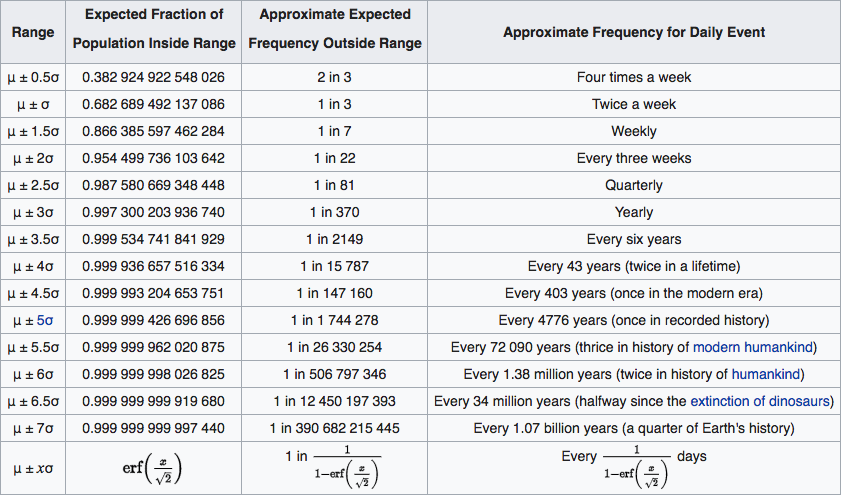

## Detecting Irregular Distributions

Since normally distributed data should follow specific rule so the likelihood that 5 points in a row all fall between the 2 and third deviation is extremely rare (8.1-11%  (0.003^5)).  

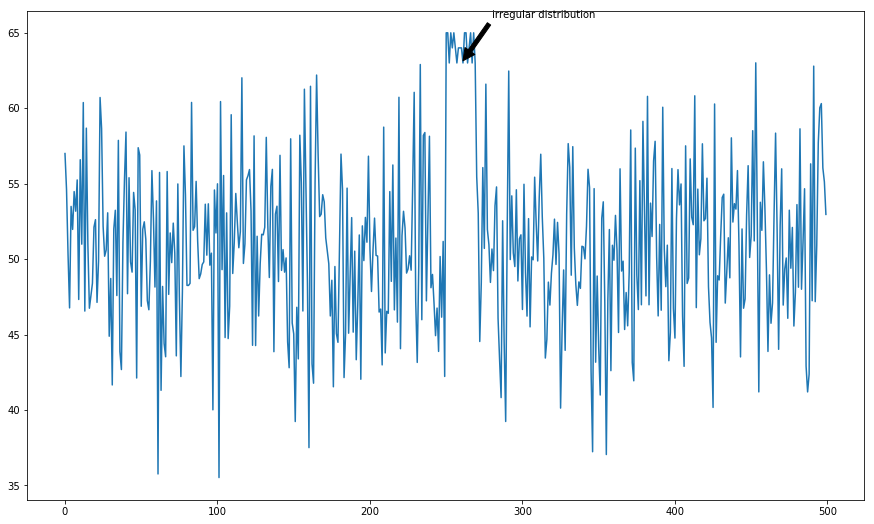

In [72]:
# create normal data with a small window of
mu, sigma = 50, 5

y = np.random.normal(mu, sigma, 500)
for i in range(250, 270,1):
    y[i] = np.random.randint(63, high=66, size=1)
x = [x for x in range(500)]

fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
# plot upper bounds
ax.plot(x, y)

ax.annotate('irregular distribution', xy=(260, 63), xytext=(280, 66),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )



Though none of the points are outliers, the small section of points are all in the same boundary which is causes an anomaly.  We can create function to look for this type of pattern.  For now will just cover the mean + 3 * sigma but it could be consecutive points in any sigma range.

In [73]:
def find_irreg_dist(data, consecutive_points=5):
    """ return an array of x coordinates where the points indidcate a irregular distribution """
    mu = np.mean(data)
    sigma = np.std(data)
    point_counter = 0
    vline = []
    triggering = False
    for i, x in enumerate(data):
        if x > mu+(2 * sigma):
            point_counter += 1
        else:
            if triggering:
                vline.append([i - point_counter, i])
                triggering = False
            point_counter = 0
        if point_counter >= consecutive_points:
            triggering = True
    return vline

Now we plot the chart again with lines indicating the window(s) for the irregular distribution.

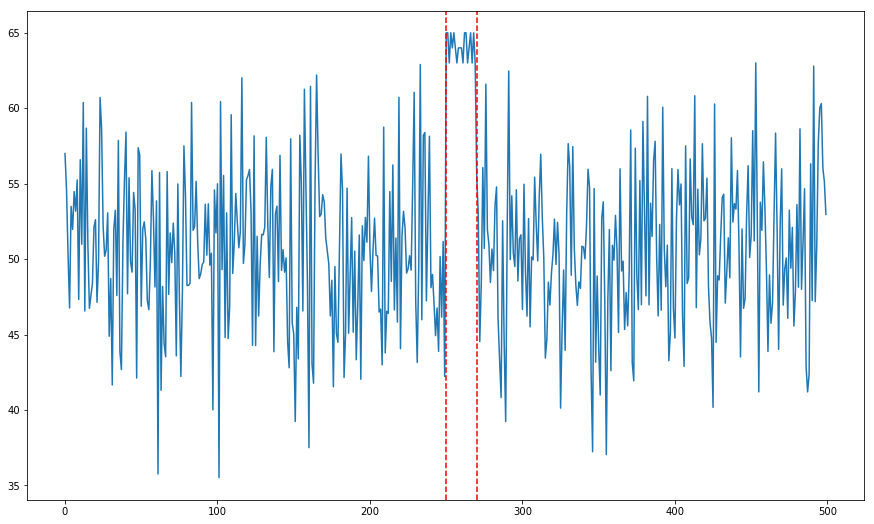

In [77]:
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
# plot upper bounds
ax.plot(x, y)

for pair in find_irreg_dist(y):
    ax.axvline(x=pair[0], color='r', linestyle='--')
    ax.axvline(x=pair[1], color='r', linestyle='--')


## Detecting Window Irregularites

There can be windows within the series where the mean and deviation change too much, that can be an anomalous window of data.